In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

import os
import sys
import annoy
from annoy import AnnoyIndex
import random

import glob

from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import RandomForestClassifier


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         #'feature_linear_trend_magn_r', # cadence removal
                         #'feature_linear_trend_sigma_magn_r',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         #'feature_period_s_to_n_0_magn_r', # cadence removal
                         #'feature_period_1_magn_r', 
                         #'feature_period_s_to_n_1_magn_r', # cadence removal
                         #'feature_period_2_magn_r', 
                         #'feature_period_s_to_n_2_magn_r', # cadence removal
                         #'feature_period_3_magn_r', 
                         #'feature_period_s_to_n_3_magn_r', # cadence removal
                         #'feature_period_4_magn_r', 
                         #'feature_period_s_to_n_4_magn_r', # cadence removal
                         #'feature_periodogram_amplitude_magn_r',
                         #'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                         #'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         #'feature_linear_trend_magn_g', # cadence removal
                         #'feature_linear_trend_sigma_magn_g',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         #'feature_period_s_to_n_0_magn_g', # cadence removal
                         #'feature_period_1_magn_g', 
                         #'feature_period_s_to_n_1_magn_g', # cadence removal
                         #'feature_period_2_magn_g', 
                         #'feature_period_s_to_n_2_magn_g', # cadence removal
                         #'feature_period_3_magn_g', 
                         #'feature_period_s_to_n_3_magn_g', # cadence removal
                         #'feature_period_4_magn_g', 
                         #'feature_period_s_to_n_4_magn_g', # cadence removal
                         #'feature_periodogram_amplitude_magn_g',
                         #'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                         #'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
  'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
# #  'zPSFFluxErr',
 'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
 'zKronFlux',
# #  'zKronFluxErr',
 'zKronRad',
# #  'zexpTime',
  'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
  'ymomentXX',
  'ymomentXY',
  'ymomentYY',
  'ymomentR1',
  'ymomentRH',
  'yPSFFlux',
# #   'yPSFFluxErr',
  'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
 'yKronFlux',
# #  'yKronFluxErr',
 'yKronRad',
# #  'yexpTime',
  'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
   'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

feature_names_tns = ['has_tns', 'tns_cls', 'spec_z', 'report_group']

lc_and_host_features = feature_names_r_g+feature_names_hostgal
lc_and_host_and_tns_features = lc_and_host_features + feature_names_tns

In [3]:
def plot_conf_matrix(y_test, y_pred, labels, title, kind, figsize=(6, 4)):
    if kind == 'completeness':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    if kind == 'purity':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='pred')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap, annot=annotations, fmt='s', cmap='Blues', vmin=0, vmax=1, annot_kws={"fontsize":18})
    plt.title(title, fontsize=24)
    plt.ylabel('True class', fontsize=24)
    plt.xlabel('Predicted class', fontsize=24)
    #plt.show()

In [27]:
def plot_RFC_prob_vs_lc(dataframe, anom_thresh):
    import antares_client

    df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/CVAE_dataframes"
    anom_thresh = anom_thresh

    num_anom_epochs_l = []
    anom_ztfid_l, tnscls_l = [],[]
    for anom_ztfid, tnscls in zip(dataframe.index, dataframe.tns_cls):
        print(anom_ztfid, tnscls)
        try:
            lc_and_hosts_df = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
        except:
            print(f"couldn't feature space as func of time for {anom_ztfid}. Make anom epoch -9")
            num_anom_epochs_l.append(-9)
            continue

        lc_and_hosts_df = lc_and_hosts_df.dropna()
        anom_obj_df = lc_and_hosts_df[lc_and_host_features]

        
        try:
            pred_prob_anom = 100 * clf.predict_proba(anom_obj_df)
            num_anom_epochs = len(np.where(pred_prob_anom[:, 1]>=anom_thresh)[0])
            num_anom_epochs_l.append(num_anom_epochs)
        except:
            print(f"{anom_ztfid} has some NaN host galaxy values from PS1 catalog. Skip!")
            continue

        try: 
            #anom_idx = np.where(pred_prob_anom[:, 1]>=50)[0][0]
            orig = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
            diff = len(orig)-len(pred_prob_anom)
            #if len(np.where(pred_prob_anom[:, 1]>=anom_thresh)) == 1:
            if not np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0] == 0:
                anom_idx = lc_and_hosts_df.loc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]].obs_num + diff
            else: anom_idx = lc_and_hosts_df.iloc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]].obs_num + diff
            anom_idx_is = True

        except: 
            print(f"Prediction doesn't exceed anom_threshold of {anom_thresh}% for {anom_ztfid}.")
            anom_idx_is = False

        ztf_id_ref = anom_ztfid 

        ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

        try: df_ref = ref_info.timeseries.to_pandas()
        except: 
            print(f"No ref_info.timeseries.to_pandas() for {anom_ztfid}. Continue...")
            continue

        print(num_anom_epochs)
        anom_ztfid_l.append(anom_ztfid), tnscls_l.append(tnscls)

        df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
        df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

        mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
        mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,10))
        ax1.invert_yaxis()
        ax1.errorbar(x=df_ref_r.ant_mjd, y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
                    label=f'REF: {ztf_id_ref}')
        ax1.errorbar(x=df_ref_g.ant_mjd, y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
        #ax1.axvline(x=lc_and_hosts_df.loc[lc_and_hosts_df.loc[anom_idx].obs_num].mjd_cutoff)
        if anom_idx_is == True:
            ax1.axvline(x=lc_and_hosts_df[lc_and_hosts_df.obs_num == anom_idx].mjd_cutoff.values[0])
        #ax1.set_xlim(min(df_ref_r.ant_mjd), max(df_ref_r.ant_mjd))
        ax1.set_ylabel('Mag')


        print(f'https://alerce.online/object/{anom_ztfid}', tnscls)
        ax2.plot(lc_and_hosts_df['mjd_cutoff'], pred_prob_anom[:, 0], label='p(Normal)')
        ax2.plot(lc_and_hosts_df['mjd_cutoff'], pred_prob_anom[:, 1], label='p(Other)')
        #ax2.axhline(y=50)

        ax2.set_ylabel('Probability (%)')


        #ax2.set_xlim(min(df_ref_r.ant_mjd), max(df_ref_r.ant_mjd))

        plt.xlabel('mjd_cutoff')
        plt.legend()
        plt.show()
        
def plot_RFC_prob_vs_lc_ztfid(anom_ztfid, anom_thresh, df_path):
    # Predict Excluded Object
    import antares_client
    
    df_path = df_path
    anom_thresh = anom_thresh

    try:
        lc_and_hosts_df = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
    except:
        print(f"couldn't feature space as func of time for {anom_ztfid}. pass.")
        pass

    lc_and_hosts_df = lc_and_hosts_df.dropna()
    anom_obj_df = lc_and_hosts_df[lc_and_host_features]

    try:
        pred_prob_anom = 100 * clf.predict_proba(anom_obj_df)
        num_anom_epochs = len(np.where(pred_prob_anom[:, 1]>=anom_thresh)[0])
    except:
        print(f"{anom_ztfid} has some NaN host galaxy values from PS1 catalog. Skip!")
        return

    try: 
        #anom_idx = np.where(pred_prob_anom[:, 1]>=50)[0][0]
        orig = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
        diff = len(orig)-len(pred_prob_anom)
        anom_idx = lc_and_hosts_df.loc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]].obs_num + diff
        anom_idx_is = True

    except: 
        print(f"Prediction doesn't exceed anom_threshold of {anom_thresh}% for {anom_ztfid}.")
        anom_idx_is = False
    
    ztf_id_ref = anom_ztfid 

    ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

    df_ref = ref_info.timeseries.to_pandas()

    df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
    df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

    mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,10))
    ax1.invert_yaxis()
    ax1.errorbar(x=df_ref_r.ant_mjd, y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
                label=f'REF: {ztf_id_ref}')
    ax1.errorbar(x=df_ref_g.ant_mjd, y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
    if anom_idx_is == True:
        ax1.axvline(x=lc_and_hosts_df[lc_and_hosts_df.obs_num == anom_idx].mjd_cutoff.values[0])
    #ax1.set_xlim(min(df_ref_r.ant_mjd), max(df_ref_r.ant_mjd))

    print(f'https://alerce.online/object/{anom_ztfid}')
    ax2.plot(lc_and_hosts_df['mjd_cutoff'], pred_prob_anom[:, 0], label='p(Normal)')
    ax2.plot(lc_and_hosts_df['mjd_cutoff'], pred_prob_anom[:, 1], label='p(Other)')
    #ax2.axhline(y=50)

    #ax2.set_xlim(min(df_ref_r.ant_mjd), max(df_ref_r.ant_mjd))

    plt.xlabel('mjd_cutoff')
    plt.ylabel('Probability (%)')
    plt.legend()
    plt.show()
    
def save_RFC_prob_vs_lc_ztfid(anom_ztfid, anom_thresh, df_path, clf, full_timeseries=True):
    df_path = df_path
    anom_thresh = anom_thresh

    try:
        lc_and_hosts_df = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
    except:
        print(f"couldn't feature space as func of time for {anom_ztfid}. pass.")
        return

    lc_and_hosts_df = lc_and_hosts_df.dropna()
    
    try:
        anom_obj_df = lc_and_hosts_df[lc_and_host_features]
    except:
        print(f"{anom_ztfid} has some NaN LC features. Skip!")
        return

    if full_timeseries: #default, full timeseries
        try:
            pred_prob_anom = 100 * clf.predict_proba(anom_obj_df)
            num_anom_epochs = len(np.where(pred_prob_anom[:, 1]>=anom_thresh)[0])
        except:
            print(f"{anom_ztfid} has some NaN host galaxy values from PS1 catalog. Skip!")
            return

        try: 
            #anom_idx = np.where(pred_prob_anom[:, 1]>=50)[0][0]
            orig = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
            diff = len(orig)-len(pred_prob_anom)
            anom_idx = lc_and_hosts_df.loc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]].obs_num + diff
            anom_idx_is = True
            print("Anomalous during timeseries!")

        except: 
            print(f"Prediction doesn't exceed anom_threshold of {anom_thresh}% for {anom_ztfid}.")
            anom_idx_is = False
            
    if not full_timeseries: # full LC ONLY
        anom_obj_df = pd.DataFrame(anom_obj_df.iloc[-1]).T # last row of df to test "full LC only"
            
        try:
            pred_prob_anom = 100 * clf.predict_proba(anom_obj_df)
            num_anom_epochs = len(np.where(pred_prob_anom[:, 1]>=anom_thresh)[0])
        except:
            print(f"{anom_ztfid} has some NaN host galaxy values from PS1 catalog. Skip!")
            return

        if num_anom_epochs == 1: 
            anom_idx_is = True
            print("Anomalous at end of full LC!")
        else:
            print(f"Prediction doesn't exceed anom_threshold of {anom_thresh}% for {anom_ztfid}.")
            anom_idx_is = False
        
    if anom_idx_is == True:
        anom_idx_is = "Other"
    elif anom_idx_is == False:
        anom_idx_is = "Normal"
    else: 
        anom_idx_is = "???"
        
    return anom_ztfid, anom_idx_is

## Load pickle

In [5]:
n_estimators=100 #3500
max_depth=35 #35
random_state=11
max_features=35 # {“sqrt”, “log2”, None}, int or float, default=”sqrt” - sqrt(120) ~ 10
#class_weight={"None": 1, "SLSN-II": 1, "SN II": 1, 'SN IIP': 1, 'SN IIb': 1, 'SN IIn': 1, 'SN Ia': 1,
#       'SN Ia-91T-like': 1, 'SN Ib': 1, 'SN Ic': 1, 'SN Ic-BL': 1, 'TDE': 1} #"balanced"
class_weight={"Normal": 1, "Other": 1} #"balanced"

figure_path = f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/RFC/SMOTE_train_test_70-30_min14_kneighbors8/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced/figures"
model_path = f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/RFC/SMOTE_train_test_70-30_min14_kneighbors8/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced/model"
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
    
if not os.path.exists(model_path):
    os.makedirs(model_path)

cm_path = f"{figure_path}/confusion_matrix/"
if not os.path.exists(cm_path):
    os.makedirs(cm_path)

In [6]:
with open(f'{model_path}/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced.pkl', 'rb') as f:
    clf = pickle.load(f)

In [28]:
%%time

fps = glob.glob("/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/before_lc-feature-extractor_tns_search/timeseries/*")

ztfid_l, anom_idx_is_l = [], []
for fp in fps:
    ztfid = fp.split('/')[-1].split('_')[0]
    
    try:
        anom_ztfid, anom_idx_is = save_RFC_prob_vs_lc_ztfid(anom_ztfid=ztfid, 
                              anom_thresh=50, 
                              df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/before_lc-feature-extractor_tns_search/timeseries",
                              clf=clf,
                              full_timeseries=False
                             )
    except: continue
    ztfid_l.append(anom_ztfid), anom_idx_is_l.append(anom_idx_is)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abxfunp.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aafwrhf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abdduix.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aayjyhp.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acbjlnt.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abxezim.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF20abfhway.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abmxovj.
Prediction doesn't exceed anom_threshold of 50% for ZTF20ablxtlp.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abfvovo.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF20abavnaw.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF20aayeims.
Prediction doesn't exceed anom_threshold of 50% for ZTF19adbmewx.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaljgcp.
ZTF19abpangr has some NaN LC features. Skip!
ZTF19aanxufb has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF18aarbaba.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aamgdkb.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acvwllm.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanircs.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aahptds.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aculypc.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanfqug.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abetehf.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Prediction doesn't exceed anom_threshold of 50% for ZTF19aboxjlj.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaurzce.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abpbbxx.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abetewu.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abwsagv.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF18abhxidv.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abahvdh.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abomiel.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aamqslk.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aadcdzj.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abjdjge.
ZTF19acbihxh has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF18adazeua.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aawgrcu.
ZTF19aawhniz has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abdznxo.
Prediction doesn't exceed anom_threshold of 50% for ZTF19adbpulv.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abfsemq.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abxekxi.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acytcsg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aatgznl.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acignlo.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abqsvgf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acennqf.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acbwhqc.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aceckdq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abvalfd.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aamovgw.
ZTF20aaporoa has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abqhobb.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aawupxb.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abqxhhr.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaileug.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abacxod.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aakpigz.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abmcwtd.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abgbfyk.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aahzyep.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF19acbmxxh.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aavnnzx.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abcejfo.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aamggmk.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaiawlj.
Anomalous at end of full LC!


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abdoznh.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aapocyd.
ZTF20aappgod has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aakiwxx.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanuipr.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acelcan.
ZTF20aazchcq has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aarixue.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF18abaxlpi.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aahfobk.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abgfljj.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acbkyma.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abtfnpl.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aaxcbvg.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aamfpcj.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acdjiml.
Anomalous at end of full LC!
Anomalous at end of full LC!


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF19aauxxgk.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abzgfhl.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaavvlv.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aazlsfj.
ZTF19acrddcz has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20abeljuj.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aalejtl.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aarfnto.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aacexgb.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abiqnpv.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavmgtv.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aapdgaw.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abkdeae.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aakswrb.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaycmhl.
Prediction doesn't exceed anom_threshold of 50% for ZTF18ablqehq.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abndzyc.
ZTF18abixrei has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF20abyskia.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acyjzeo.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abuclhk.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acypppb.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abcysdx.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abhmnom.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20abushtf.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abchhuw.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aarflsx.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abhbqbh.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abupbub.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abqyoxt.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF19aajwdqt.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abcxnjl.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaqtnam.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abrnvwf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aamohrk.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abcicrq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acihlft.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aboquuv.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abcndvf.
ZTF19abhdqlq has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aafxrcv.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acnkeji.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abqlrtb.
ZTF19aapwbvm has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aarnqzw.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19achagst.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abdiqdh.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abpuxna.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aakrhzj.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aakpccq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abgjlef.
Anomalous at end of full LC!


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF20abowpvf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aczlldp.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aarblcr.
Anomalous at end of full LC!
ZTF18abckujq has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19achjqbk.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF20aammhli.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaxokeg.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aabqiti.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aarmznp.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abzulhk.
Prediction doesn't exceed anom_threshold of 50% for ZTF19actnyae.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aaoojli.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abvhduf.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abtnpwt.
ZTF20aayrobw has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20abthxfr.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF19acoaoty.
ZTF19acduloz has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF18aavnvmp.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acnjwgm.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abcfzdy.
Anomalous at end of full LC!


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF18abeegsl.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abmapla.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abimsyv.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanhdwf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acordoi.
ZTF19aarnrbw has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aautscv.
ZTF19aahuian has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aauowam.
ZTF19aceqvhl has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20abpvolc.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aazpvdy.
ZTF19aasmddt has some NaN LC features. Skip!
ZTF20aasxfcd has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF18ablwtkf.
ZTF20aambtea has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aalxlpp.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavwbpc.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaqepvb.
Prediction doesn't exceed anom_threshold of 50% for ZTF19accbeju.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acbvllm.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abzvyew.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aanovps.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aawgolt.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aawtnqd.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abegopd.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaqqoqs.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF18abjijwk.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acfxbki.
ZTF19abzyiba has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19acmywjc.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aawmkja.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acgdfjt.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19ablovot.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abqwtfu.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abpeyat.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavhypb.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aahtjsc.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aavbjfp.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aahqcup.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavxfib.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aatqgeo.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abvvpoh.
ZTF18aaqvuhl has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aamhqow.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abkrbjt.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aazhyrs.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abxyiqi.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aamdyal.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abypkpz.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acyplkt.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abbovuc.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acbvujw.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abdqaao.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaifyrs.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abxihut.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aczkjxn.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF18ablongw.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abbpkpa.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abqbavl.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aazcnrv.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaqshoz.
ZTF20aadccel has some NaN LC features. Skip!
ZTF20aaivhra has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aadcitq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aclkbqc.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20abwavab.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acyflhv.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abbpeqo.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aafckit.
ZTF19aamuvak has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20abatmsa.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20abjwjrx.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abglmpf.
Anomalous at end of full LC!
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aammnnm.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaldqvh.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF18abdiwpt.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aathacy.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aawafvn.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavxikq.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abqcvtk.
Prediction doesn't exceed anom_threshold of 50% for ZTF19accobqx.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaupkrl.
Prediction doesn't exceed anom_threshold of 50% for ZTF19ablpasc.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aczrmvs.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abjbgjj.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aboaeqy.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aamuxso.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abwscog.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aammlzn.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abyigib.
Anomalous at end of full LC!
ZTF18abmjvpb has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavorpa.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aandwrl.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aarxrem.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abyfgri.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaxnkos.
ZTF19abpypvc has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19ablpfhz.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abmdfcy.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20acdalpf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaqdkrm.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abvgnxg.
ZTF19abalrbb has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aauvkxu.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acaotrk.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abpmetl.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavnxwj.
ZTF19aapvhhp has some NaN LC features. Skip!
ZTF19adakmbh has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abidfsb.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abnimpq.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aauxepf.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abbrptu.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaghlkv.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abciflj.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaeujsk.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acpmuwu.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aasitrr.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aauompx.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aamtwwv.
ZTF19acvrgde has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aayejww.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Prediction doesn't exceed anom_threshold of 50% for ZTF19aapzbjr.
ZTF19acbwjue has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20abyrmdl.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abkcril.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abclalx.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abrcpnj.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abxyadt.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

ZTF18abkjnqy has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20abjwuuv.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaetrle.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abrlvij.
Prediction doesn't exceed anom_threshold of 50% for ZTF19adbnlki.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abtsecq.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF19aatvlfl.
Prediction doesn't exceed anom_threshold of 50% for ZTF19achajnc.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaullwp.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abfiqjg.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aahatvc.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaormnl.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aammtwx.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF18abdmgab.
Prediction doesn't exceed anom_threshold of 50% for ZTF19adajqcq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acckggd.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19acasiwm.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanjjgr.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF20abswdbg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aasfsoi.
ZTF19abaukyt has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF18abdrmin.
Prediction doesn't exceed anom_threshold of 50% for ZTF19adaxzax.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aamhhae.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aamenwg.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abqrhvt.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aatlqdf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abgcbey.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abquyqj.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acxzdht.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acxldra.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abccojn.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abhzdjp.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aafclqz.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abhjhes.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF20aafgbrf.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abeeyre.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaezaxk.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aazqiel.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acftbsn.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF20aaurhzc.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abtnftd.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaglivt.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aamxuwl.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abdajyr.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abnmahn.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavivbl.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abqmpsr.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaupkev.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaxfcpq.
ZTF19aatnefp has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaepsqa.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaqasrq.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF19aanuuen.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaesewy.
ZTF18aaiiigm has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20abhlncz.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abcezmh.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aawgxdn.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aartuli.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaoyjoz.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aazquhc.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aawcjrx.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abymhad.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abanayw.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF19abgurml.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaxdrjn.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aauomaf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aakiyly.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acekbyz.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaifzfk.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF19acbykmk.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abfsxpw.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aascwar.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acxysob.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaobwpx.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abfdszw.
ZTF19acyndpl has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19acgzzea.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aavnnqo.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aawozzj.
Prediction doesn't exceed anom_threshold of 50% for ZTF19ackjmge.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acigkma.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aaghpdc.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aazpwen.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acyjysk.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abudlps.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavkptg.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aaeoqst.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aayhacx.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abcecfi.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abafrvy.
ZTF19aaknemm has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19ablfcjr.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aanvpzo.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aayubpi.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aahqbsr.
ZTF18abshmro has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abkdrir.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaphntn.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abjamgc.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF20aabqjht.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abyfmjr.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abwsecm.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aceshib.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aamdqiz.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abdxoeu.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aarfyvc.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF18aayjvve.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acokzjy.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abeyvwv.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aakpcfi.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aayvylv.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaurjbj.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF19abfvhlx.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aazjztm.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abclfee.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aamttni.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aailptb.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abgoocl.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abrnavu.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF20aacbtgq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acardcs.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abdkimx.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acbmojx.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaxffum.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abxgxjd.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF20aaawbkz.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaqxcfs.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aazgxgk.
Prediction doesn't exceed anom_threshold of 50% for ZTF19ababmsi.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abjrfqx.
ZTF19aauuzlr has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaurknv.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aazpapu.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaeopvv.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aayxxew.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abpxcaf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aayfaum.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acwrqtv.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF18aaqehoc.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaqkdwu.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aahapgw.
ZTF20ababkom has some NaN LC features. Skip!
ZTF20aazwuin has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aahirkk.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abctnpk.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF19abzqwpr.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abawntz.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aamqebl.
Prediction doesn't exceed anom_threshold of 50% for ZTF19accmaxo.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaeuxqk.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abxdnhr.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF20abjyorg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abattvp.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aazgrfl.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abyjgal.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abeyuxt.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aafcjln.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aaeszsm.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abcsbux.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavnwxf.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abwdwoa.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abozuxh.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aazooyu.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaklquv.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF19acfthre.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abgnuri.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abirbpd.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aawyepw.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aahpxzz.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aahidaa.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abmcxct.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aaideho.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaxmtxg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acyiqnw.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abhibzk.
ZTF18abktphg has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaoikti.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF18abkhcwl.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abrcvzz.
ZTF19abzwtiu has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20acdnmpv.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acdxkek.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aauonld.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abqqmui.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acbpwwg.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abgijph.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaqcqkv.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abffaxl.
ZTF19abzkyjy has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abimlck.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aazdxlx.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aapemqu.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abfcsnk.
Anomalous at end of full LC!


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aavvaup.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aclljyq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavnzti.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acryaon.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aakkrjm.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaxptsd.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acnqsui.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abzkexb.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abinjcy.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abqlykl.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aauvjws.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aanvliy.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abandzh.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

ZTF19aafmwfc has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abqqrib.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abaeyqw.
ZTF19aaqtcmy has some NaN LC features. Skip!
ZTF18aarldnh has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aakoasy.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aayvubx.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF20aacwxut.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aayivxm.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaswzdm.
Prediction doesn't exceed anom_threshold of 50% for ZTF20acexvcz.
Prediction doesn't exceed anom_threshold of 50% for ZTF19actldas.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acchjle.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acjdwqv.
ZTF18abjyime has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abdoior.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aamerev.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19acclzaw.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aawqckx.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF19adbricc.
ZTF19abioohk has some NaN LC features. Skip!
ZTF20abqkaoc has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abobxik.
ZTF19acrdcwh has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaxicpu.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acyjzbe.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaflaug.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acyksfd.
ZTF18abwwfyo has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aazhxsw.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavvozj.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abesqnb.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abpbqor.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abgqwed.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20abekbzp.
ZTF20aaeipdz has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abzzgec.
ZTF19adbfhal has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaluprf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abdjsss.
ZTF18abespgb has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aazlpel.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aayabqe.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abegoix.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abdkgns.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aavdcxo.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abcvush.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aathllr.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF19abvgwvp.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abueupg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acbihyi.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abxvjzn.
ZTF19acjurot has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF19abrmlxu.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acxowrr.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abjpkdz.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abyxnjo.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abobkii.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aaqtlwo.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acmdpyr.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abgncfz.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abjgdko.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acyqdxa.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abzzhgx.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aarqmjs.
Anomalous at end of full LC!
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF20abxidyb.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abszyjg.
ZTF18abfcmjw has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aahubwe.
ZTF19aatudsq has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aarhxgn.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abxdnzt.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abmpoxa.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aamhhey.
ZTF19abcunya has some NaN LC features. Skip!
ZTF20aafcmfi has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abiztut.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abdviwl.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aavuziy.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaetvkh.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abtulak.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaujiwc.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acymzwh.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aaumlmu.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaxcntm.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aanyxvu.
Prediction doesn't exceed anom_threshold of 50% for ZTF20acberfr.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaurhox.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20abmxstg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aadolpe.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aalcwjt.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aczeomw.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abgtvhl.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acgjojy.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaybfsd.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavmlqh.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aajivpr.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaoufjt.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aabqisb.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acrwvao.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aamvmer.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acvgjme.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abdxffu.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acftude.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abhgrff.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aagzqsb.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abujoya.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abdfazk.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abatvit.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aazhzna.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abrffom.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abvdbyx.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acewotx.
ZTF19adalouc has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aatppnn.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanbojt.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abbjwgc.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaysiwt.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaxpjpq.
ZTF19acmbkmr has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20abjbiqf.
ZTF19abqgrht has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF18abcsgvj.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aargqez.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aayqait.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abvjdfc.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abdyawn.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aauqywe.
ZTF19abggmim has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19acxndsk.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aalrksw.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aarprog.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaokist.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acbiwjk.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF20aahgmud.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanmdsr.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaxxepr.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aazsabq.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abonvte.
ZTF20aamqxyi has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF18abjtger.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF19aculgvn.
Prediction doesn't exceed anom_threshold of 50% for ZTF19adbsfpf.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaunfqq.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aabcnkx.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aansktb.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF19aarfksi.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acbwilc.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acwrujg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aapbgmp.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aazdcmj.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aauwjla.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF19acblhgq.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abmsqaa.
ZTF19aapceyj has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abcejoa.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aauitks.
Prediction doesn't exceed anom_threshold of 50% for ZTF19ababigc.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aalemmz.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aacevxq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abqanpy.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acchink.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acgjosf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acytcoi.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF19aaeopqn.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaxvpsw.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acqypso.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aawpcel.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaiqiti.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aaktpns.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abixkhh.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abdzrxo.
Prediction doesn't exceed anom_threshold of 50% for ZTF19achetvw.
ZTF20aayngca has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavlnjz.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aapadwx.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abqimia.
ZTF20abpucsd has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aakfofq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19adcdgca.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acvijnj.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abqrrto.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abgdspk.
ZTF19actnwlw has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aafrjqw.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF18abdgwxn.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abukbit.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acgcdas.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abeoicg.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aayvqhl.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aahpwym.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abqsvue.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF19aakrawk.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaeicsm.
Prediction doesn't exceed anom_threshold of 50% for ZTF19actzjrf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aazpvyr.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaohyqj.
Prediction doesn't exceed anom_threshold of 50% for ZTF19achtewn.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acmwszk.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abhphah.
ZTF18abjyjdz has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abzsjpn.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acmblbi.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aatqief.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acgemzm.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aavrukn.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF18abojpnr.
ZTF19acjerzj has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20abbpory.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acsfvog.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abeeyrn.
ZTF19aaklbok has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19acdabep.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aatvljp.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acechlg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abzsitm.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acukucu.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aarmnnd.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abfklsy.
Prediction doesn't exceed anom_threshold of 50% for ZTF18absnqyo.
ZTF20aaivjce has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aapcoqg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abjpntj.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aazxcvl.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abzsogy.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaoyech.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abpyplw.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF18aaizerg.
ZTF20aamcvyp has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaksrgj.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abefaya.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abaknoz.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abxtdgh.
ZTF19acmxidf has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abxvtmy.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aazpphd.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abpglei.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aahshhp.
ZTF19aasszud has some NaN LC features. Skip!
ZTF19abgmxwn has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abyjhpz.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaawmxq.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF19acbacvu.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abqwsuf.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaytovs.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aakzash.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aatfqzb.
ZTF20aasxrko has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abjarhj.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF19acigqdd.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abyuzch.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanirdx.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abdfwur.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aafcnem.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aatzygk.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abasxkg.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaxrvzj.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abiahik.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abopyyu.
Prediction doesn't exceed anom_threshold of 50% for ZTF19actfqhp.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abrogbl.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF19aaripqw.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abzmpku.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abjwuju.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aayuyak.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acngsnc.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aazblzy.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acojxzo.
ZTF20aamdyln has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavqics.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaermez.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aabcouv.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aagjpmt.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


Prediction doesn't exceed anom_threshold of 50% for ZTF19acgbzam.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abmectx.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abuxhqc.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaifyvz.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aarhhfx.
ZTF18adaykvg has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF19abuazly.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF18abmjvuf.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abefbpl.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abzvvkb.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acmwkul.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acxowwt.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abpelgt.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abfibel.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abgpksj.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aahgejq.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aapreis.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaqrime.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abqlawg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19ablfaey.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abxjrge.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aapwnmb.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF20aadxcsc.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aahirqq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acitnck.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aapjiwl.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abeldyn.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acszmgx.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


Prediction doesn't exceed anom_threshold of 50% for ZTF18abixkjh.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanijpu.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavaikm.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aawadcp.
ZTF19aaljeup has some NaN LC features. Skip!
ZTF19aailqir has some NaN LC features. Skip!
Anomalous at end of full LC!


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF19abqviuy.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acazbqm.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aakodiq.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aarkpif.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abzprpk.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aczjytt.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aasekcx.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abswjae.
ZTF19aalahqa has some NaN LC features. Skip!
ZTF20aaevgyr has some NaN LC features. Skip!
ZTF19aartylj has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aadyukn.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abloktg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abguzsx.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abgppki.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acrenwk.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aboyujf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanhlxe.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aafdeza.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abbvsiv.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abtsnyy.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acyqwlm.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaxkfos.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abvdgqo.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavjlkx.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abgevcw.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abmbycd.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF18ablqlzp.
ZTF19abzhzet has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaypehm.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aadvunl.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abyzuos.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abfwuwn.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aamsetj.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF19abdkecj.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acyfkbf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aayslow.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abealop.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aapnzde.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abjsmmv.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF18ablqkud.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aalrptc.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaywban.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abqmmhn.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aamkyyx.
ZTF19acxniuc has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF18ablhvfr.
ZTF19abhpvfq has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abdkdir.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abzlmwn.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaydmkh.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaazjwc.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acxyucu.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aamoqxy.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abjvhec.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acgxbwo.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aczmnqy.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aazcoob.
Prediction doesn't exceed anom_threshold of 50% for ZTF19adafqoe.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aarinmw.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF20abpqdgh.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aauhwbp.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abcrzfz.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aailqli.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abexfad.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaodkvl.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aamnvij.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abnktws.
ZTF19aceidtc has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19acdtpow.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aavdgib.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abimzvh.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aamazzl.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aayjsty.
ZTF19adcbpcj has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF18abcrtnq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aapeime.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acmbhvv.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abpztlw.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acekreh.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF19aaniore.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acgcshq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaujzqh.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaladlt.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aailsyx.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aclyezb.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaojnrx.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20abjlaim.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abfdsbu.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abyhxzp.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aarlukc.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acuybzx.
ZTF19aakoese has some NaN LC features. Skip!
ZTF20aaawbxl has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF19abpfxfs.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaemtgw.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acxlddi.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaraxhh.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF19aamgghn.
Anomalous at end of full LC!
ZTF19aapcnzi has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19acjwcyx.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abubagk.
Prediction doesn't exceed anom_threshold of 50% for ZTF20ablqbvc.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abqyoxj.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abeyqmx.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abdfaqi.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abpscln.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abqdadp.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaybqae.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abnagzk.
ZTF19aboudfp has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aafxftu.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aarwxum.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abpzuzd.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abajuqh.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abqefja.
ZTF19acjutrw has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abfaqqo.
Anomalous at end of full LC!


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF19aavyafo.
Prediction doesn't exceed anom_threshold of 50% for ZTF19achvpik.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aabqiiy.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abxyaqc.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abgbxzn.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF19acygjgx.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aapxocr.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aadnxgj.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abyjopm.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abpyjqx.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aakpfax.
ZTF20aasdibr has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19acjwqvo.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aauooag.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aakpcuw.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanwwlo.
Prediction doesn't exceed anom_threshold of 50% for ZTF19adajqwl.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abimhfu.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aayveer.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF19abgndlf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abaejrh.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aatvmbo.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abatffv.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abakjci.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aakozyp.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abamqxo.
ZTF19aalafip has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19acbhvgi.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acaqyjp.
Prediction doesn't exceed anom_threshold of 50% for ZTF19adajivt.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aavrloz.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abugthp.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aafnfyc.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

ZTF19aailexm has some NaN LC features. Skip!
ZTF19abfwhja has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abfqhis.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aavrzxp.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abgrcxs.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abrnvnn.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aabqiav.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF19aamhhiz.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aafnend.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acwqvvn.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavkvpw.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acbrzzr.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaykjei.
Anomalous at end of full LC!


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aavpyxo.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aauisdr.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aabqwtz.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abzplvm.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19acqupbp.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aazpkyv.
ZTF18aacemcn has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abzzuyl.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abotfag.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aawmqtd.
Prediction doesn't exceed anom_threshold of 50% for ZTF19ablrkfz.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aawfkeg.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF19aadoocn.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aalyeut.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abafmwj.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abimkwn.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aapcvxi.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abadskf.
ZTF19aaraued has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19acjqecl.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abzlsbl.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaemivw.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaqrddh.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20abbihor.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abywpkl.
ZTF19aalrfoi has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaneugz.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aculczm.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanuipj.
Prediction doesn't exceed anom_threshold of 50% for ZTF19accuyyg.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Prediction doesn't exceed anom_threshold of 50% for ZTF20aayxldg.
ZTF19acqehbt has some NaN LC features. Skip!
ZTF18abhhnnv has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF18abfgygp.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abxiqve.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abqofgc.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abxvtxk.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF20abglyot.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abkacis.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaiovoy.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acudiph.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abklljv.
ZTF19acxzafe has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaodnmm.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF19abzzhsa.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaybvye.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanmeyw.
Prediction doesn't exceed anom_threshold of 50% for ZTF19actfpma.
ZTF19acsvqrx has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaffgwg.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF20aagzzbi.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acbunmk.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abqsrfe.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abyikbv.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abgmkef.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abyqdyg.
ZTF19acjnatv has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

ZTF19abqmurd has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF18abadjhx.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aafnecv.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acbrola.
ZTF19abkcpxe has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20abixkpg.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aazzpje.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abjgyyr.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acrdqej.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aafvzhu.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abrirmk.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acxyumq.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20abpuxcc.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abcuigh.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aakyoez.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acbpzir.
ZTF19aapdkza has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaxyukr.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20abpuyau.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acdsqir.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aawxsit.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanfyey.
ZTF20aasokxu has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aawqywr.
ZTF20abrempf has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaxibpz.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF19aakljys.
Anomalous at end of full LC!
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19adcbxkw.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aawfbtg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaloqmd.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20ablkswc.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abeeyrs.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aatzlmw.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acjdufa.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanjjhk.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abvhkst.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aapbfot.
ZTF19aaxnlps has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Prediction doesn't exceed anom_threshold of 50% for ZTF20aavynba.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abqgytb.
ZTF18abdmlya has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaycomi.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaaibml.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acpgaet.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF19aanramr.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaziick.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavidqf.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abmxmsv.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaqpxtm.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF19aakthjl.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abidbya.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aceckmm.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aczllns.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aauodrj.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF20aalbjpf.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaxcxih.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaywtoc.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanyuyh.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aazgtmp.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF20aaevbvv.
ZTF19acbwccr has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aauguzk.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abeytzv.
Prediction doesn't exceed anom_threshold of 50% for ZTF19ackjene.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aazoqmh.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF19aaozpew.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aarvjhs.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aazycgy.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaekbdr.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aamhocj.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanqzhm.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acngsnb.
Prediction doesn't exceed anom_threshold of 50% for ZTF20acbeanu.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aailltc.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaghoqz.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aafciit.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaxablt.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acgmkrt.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abvanim.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acxyfkf.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aamknxn.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acchaza.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abyjjxp.
ZTF18abcyilc has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF20aamuqwn.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aasapko.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abzrhgq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aajxwnz.
ZTF19aclhnkd has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Prediction doesn't exceed anom_threshold of 50% for ZTF20aavhyel.
ZTF19aahjhoy has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaivego.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aakiyed.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaxwjmp.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aahaxjl.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abkzhpk.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF18abdefet.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abmsxxr.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aattoch.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aarbktd.
ZTF19abetjcx has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aamqlyl.
ZTF19aalxcyo has some NaN LC features. Skip!
ZTF19abmzmom has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF19abqqrgy.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aauplxw.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aadzfso.
ZTF19abanfrn has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20abxrsjb.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abxvtmn.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abekcdt.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aaerxsd.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abahsgg.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aayxupv.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abgzvff.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aampqcq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abpbopt.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abtslqm.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF19abdmdow.
ZTF19abzgdfu has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19acygjmg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aawblge.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aahggbm.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF19aaydpiq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19ablpxtf.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aatnfvj.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaptwpu.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aapfmki.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abqdkne.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abefzfc.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acmbiad.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abwsdic.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abqykei.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abxvjkn.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20abwyyjc.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acgdxel.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abgprpq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acfecsg.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abkfhzy.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aamhhgu.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20abirxmf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abbxykm.
ZTF19acaqqix has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aclobbu.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaqhtcd.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaycrgf.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acchtyp.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaznpor.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aafjjqj.
ZTF18acbwavp has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aafwbcs.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aartuev.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF19abovstj.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abhhxcp.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abrtjsf.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaurfcm.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acctpgd.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abrnklh.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abdkcib.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aayidfz.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abfdupq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acbmxky.
Anomalous at end of full LC!
ZTF20aauwuui has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF20aazpaki.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aakbtyz.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abjtgdo.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aangpkx.
ZTF19acgpkye has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aanrdek.
ZTF19acaqqke has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20abzpxxu.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acblzux.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aazixbw.
Prediction doesn't exceed anom_threshold of 50% for ZTF20acctbbw.
Prediction doesn't exceed anom_threshold of 50% for ZTF19adbnfne.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aboytzr.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acxhkvc.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aahulyd.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aafdglk.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acxqaot.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aardunx.
ZTF19acxmmys has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20abisrhp.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF18abeaipj.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aaxavsk.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aalzmiu.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acbrtbh.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abdxouw.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abhdlxp.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aavvzlw.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aazxvox.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abjibet.
ZTF19abaesgr has some NaN LC features. Skip!
ZTF20abqnctf has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaxxhib.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaxibby.
ZTF19acbvrhb has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF18acqsztr.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abisvtr.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaejtof.
ZTF18abqbuaj has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19acnzkph.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaknzba.
ZTF19acbmwtc has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aanejfr.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acgjnfz.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aayjxdv.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abgqvyr.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abzmnuk.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF19abzqywg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abuonnx.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aasijew.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aapuohr.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF19aakjbej.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aawjywv.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaomkvl.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaqtebg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanxnkd.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aayjyub.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20abbozif.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaqhelq.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aafclxb.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaznoxg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acmbekd.
ZTF20aappcup has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aanxosu.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aahtral.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavqotz.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abpbmli.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavrswr.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abcneik.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aazhtvi.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abegate.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF20abqnztv.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abfwfei.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abrbmvt.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abcwuwg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abqmjdq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abrirdm.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aassqix.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acpfnth.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF19abkgbul.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acxgwvo.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abxvles.
Prediction doesn't exceed anom_threshold of 50% for ZTF19achaspq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaugoig.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acbkczc.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


ZTF20aazbqvr has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19acyogvo.
ZTF19abgbdcp has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20ablvukx.
ZTF18abgrbjb has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aahjymt.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aavcvrm.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF20abgfekk.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aatqzim.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abazgfi.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aawoojh.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abrmmah.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abyleyk.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaxxcms.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF19abzfmak.
ZTF19abzhfjj has some NaN LC features. Skip!
ZTF19acdkzxk has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19acxxwvi.
ZTF20abmoans has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavqoop.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaqgmji.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aaillan.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aarykkb.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanuhox.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aamooex.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aaowuim.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abfqeef.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aapbgty.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abangub.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abuzpmr.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abifioh.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF18aaxqyki.
Prediction doesn't exceed anom_threshold of 50% for ZTF20ablagfg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acrcxri.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanonjt.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abzqkdz.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF18abcrxoj.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aataafd.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abgwgqj.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aacwljg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abaeyln.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abnkrcd.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF20aamaqak.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abvjcii.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aattotq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abxigfc.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aazwnwy.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abkifng.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20abqosnh.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aailmfm.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aawudku.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abqgzhh.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavxpbx.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aawjbsf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaugaam.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaleptm.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaifyab.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abdzehg.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aabqbxm.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abgaovd.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abdxyae.
ZTF18abakunn has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19acbmjrp.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aalrqbu.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aavrkxw.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abqxibq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aarnqys.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aapcvdi.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acaqqxo.
ZTF19aakluwr has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19accmxtw.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abucvgu.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

ZTF20aanaibf has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aazfvhh.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abaejto.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acgqjln.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abzhvxk.
ZTF19aaktdid has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20abejvpr.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acihfxz.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abjwvdh.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aanvsds.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanydko.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abceakp.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acmwfli.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abgfrbl.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abjozed.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abpxttd.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abqmpti.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aayprqz.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19abpgggu.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavounq.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aapfktd.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aceuacu.
Prediction doesn't exceed anom_threshold of 50% for ZTF20ablklei.
Prediction doesn't exceed anom_threshold of 50% for ZTF19adcfsdr.
Prediction doesn't exceed anom_threshold of 50% for ZTF19achtifr.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

Prediction doesn't exceed anom_threshold of 50% for ZTF19absfopz.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abeolig.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaurstb.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acgouje.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aakpcfy.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aagfjlj.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19acgemqj.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abyfbik.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aamljom.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abatdly.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aagvvnr.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aafmvdb.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaeoqqd.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF20abjpvce.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abnwldu.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abkfxfb.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abtcapa.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abxvtiy.
Prediction doesn't exceed anom_threshold of 50% for ZTF19adcdzjm.
ZTF20aaumnfl has some NaN LC features. Skip!


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Prediction doesn't exceed anom_threshold of 50% for ZTF20abkwvgc.
ZTF18aamsgjq has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abdmfgf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abnhegb.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abbhrrt.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aajjxwc.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aangier.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF20abcqpdj.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaactgu.
ZTF19abbthwy has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aamqmhj.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aboqpry.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaerqjd.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aaekkuv.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abatows.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acykaae.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavhwxs.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acqxoll.
ZTF19aavvvrc has some NaN LC features. Skip!
ZTF20acaapwk has some NaN LC features. Skip!
ZTF20aaocklb has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20aatulug.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abcekty.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abukakm.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abapyxl.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aczjsqn.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abstsxb.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aalbjqh.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aamttiw.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaifybu.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abblqtl.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aazudta.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF18abmrhom.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aadxvfj.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aayrosj.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acykjcw.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20abasxmb.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aailvhf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavnwyt.
ZTF19adaiomg has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aavnuur.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abzjpsv.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aawrumx.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaksxgp.
Prediction doesn't exceed anom_threshold of 50% for ZTF18abdbuty.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aapvogv.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aazgpar.
Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF19acspeuw.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aauoktk.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aansyyn.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abgiwkt.
Prediction doesn't exceed anom_threshold of 50% for ZTF18aarqxbw.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abvqilf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abrvagn.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abxfhrq.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20abeqsrm.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aajxhwa.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abwamby.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aamtwiz.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abjswdz.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aafmfxg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abornyn.
ZTF19aayrjnf has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aauoulb.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aansmsj.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aahqbib.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF19aclofmz.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aanfnvl.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abopflp.
Prediction doesn't exceed anom_threshold of 50% for ZTF20acbakkg.
ZTF19acrwyyb has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF20abawtpy.
Prediction doesn't exceed anom_threshold of 50% for ZTF19aadyijk.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

Prediction doesn't exceed anom_threshold of 50% for ZTF20aauombk.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aahkgcz.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abqjypm.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abgwfek.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abaszgh.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aafcgca.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF19aavnwtf.
Prediction doesn't exceed anom_threshold of 50% for ZTF19abaosan.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acshkft.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acyldun.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Anomalous at end of full LC!
Prediction doesn't exceed anom_threshold of 50% for ZTF20abjxrhg.
Prediction doesn't exceed anom_threshold of 50% for ZTF19acvlycr.
Prediction doesn't exceed anom_threshold of 50% for ZTF20aaosoct.
ZTF19acfrntd has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaywlmi.
ZTF19acgjnis has some NaN LC features. Skip!
Prediction doesn't exceed anom_threshold of 50% for ZTF19abxtcio.
Prediction doesn't exceed anom_threshold of 50% for ZTF20abazekd.
CPU times: user 41.9 s, sys: 7.12 s, total: 49.1 s
Wall time: 52.6 s


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [29]:
beforeLCFE_df = pd.DataFrame(zip(ztfid_l, anom_idx_is_l), columns=["Disc. Internal Name", "RFC_best_cls"])
beforeLCFE_df = beforeLCFE_df.set_index("Disc. Internal Name")
beforeLCFE_df

,RFC_best_cls
Disc. Internal Name,
ZTF19abxfunp,Normal
ZTF19aafwrhf,Normal
ZTF19abdduix,Normal
ZTF20aayjyhp,Normal
ZTF19acbjlnt,Normal
...,...
ZTF19acvlycr,Normal
ZTF20aaosoct,Normal
ZTF19aaywlmi,Normal


In [30]:
keep_tns_result_df = pd.read_csv('../tables/before_lc-feature-extractor_tns_search_keep_2127spec.csv', index_col="Disc. Internal Name")

keep_tns_result_df = keep_tns_result_df[keep_tns_result_df.index.isin(beforeLCFE_df.index)]
merged_df = pd.concat([keep_tns_result_df, beforeLCFE_df], axis=1)
merged_df

,Name,RA,DEC,Obj. Type,Redshift,Host Name,Host Redshift,Reporting Group/s,Discovery Data Source/s,Classifying Group/s,...,End Prop. Period,Discovery Mag/Flux,Discovery Filter,Discovery Date (UT),Sender,Remarks,Discovery Bibcode,Classification Bibcodes,Ext. catalog/s,RFC_best_cls
Disc. Internal Name,,,,,,,,,,,,,,,,,,,,,
ZTF20acdalpf,SN 2020uma,22:28:50.948,+44:38:05.12,SN Ia,0.0760,NaN,NaN,"ZTF, Pan-STARRS","ZTF, Pan-STARRS",ZTF,...,NaN,19.8400,g-ZTF,2020-09-23 06:14:24.000,ZTF_Bot1,NaN,2020TNSTR2971....1D,2020TNSCR2973....1D,NaN,Normal
ZTF20acexvcz,SN 2020ugv,01:53:30.936,+01:33:26.12,SN Ia,0.1000,SDSS J015331.03+013324.4,0.068,"ALeRCE, ZTF",ZTF,ZTF,...,NaN,20.0451,g-ZTF,2020-09-24 07:25:17.999,ALeRCE,NaN,2020TNSTR2941....1F,2020TNSCR3289....1D,NaN,Normal
ZTF20acdnmpv,SN 2020uca,19:43:28.840,+65:11:33.55,SN Ia,0.0650,NaN,NaN,"SGLF, ZTF, ATLAS","ZTF, ATLAS",ZTF,...,NaN,20.8140,r-ZTF,2020-09-21 03:38:43.000,Perez-Fournon,NaN,2020TNSTR2922....1A,2020TNSCR3140....1G,NaN,Normal
ZTF20acctbbw,SN 2020tzl,02:18:40.800,+50:47:13.03,SN Ia,0.0500,WISEA J021840.75+504712.5,NaN,"ALeRCE, ATLAS","ZTF, ATLAS",ZTF,...,NaN,20.4904,r-ZTF,2020-09-20 08:51:28.996,ALeRCE,NaN,2020TNSTR2887....1F,2020TNSCR3289....1D,NaN,Normal
ZTF20acbeanu,SN 2020txg,01:02:28.857,-12:47:59.99,SN Ia,0.0600,NaN,NaN,"ZTF, ATLAS","ZTF, ATLAS",ZTF,...,NaN,18.9600,r-ZTF,2020-09-21 08:24:11.232,ZTF_AMPEL_COMPLETE,NaN,2020TNSTR2900....1N,2020TNSCR2954....1D,NaN,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18aaqqoqs,SN 2018cbh,13:51:52.890,+47:15:25.16,SN Ia-91T-like,0.0800,NaN,NaN,ZTF,ZTF,ZTF,...,NaN,20.9600,g-ZTF,2018-05-06 05:19:40.000,ZTF_Bot1,NaN,2018TNSTR.719....1F,2019TNSCR.826....1F,NaN,Normal
ZTF18aataafd,SN 2018cbf,14:19:20.942,+36:10:19.53,SN Ia,0.0770,NaN,NaN,"ZTF, Pan-STARRS","ZTF, Pan-STARRS",ZTF,...,NaN,20.1100,g-ZTF,2018-05-10 07:39:21.000,ZTF_Bot1,NaN,2018TNSTR.719....1F,2018TNSCR1071....1F,NaN,Normal
ZTF18aavnvmp,SN 2018bxr,13:38:47.280,+30:57:34.50,SN Ia,0.0640,NaN,NaN,"ZTF, ATLAS","ZTF, ATLAS",ZTF,...,NaN,20.0900,r-ZTF,2018-05-19 06:28:48.000,ZTF_Bot1,NaN,2018TNSTR.705....1F,2018TNSCR1071....1F,NaN,Normal


In [31]:
np.unique(merged_df["Obj. Type"])

array(['SLSN-I', 'SLSN-II', 'SN II', 'SN II-pec', 'SN IIP', 'SN IIb',
       'SN IIn', 'SN Ia', 'SN Ia-91T-like', 'SN Ia-91bg-like',
       'SN Ia-CSM', 'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib/c',
       'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE'], dtype=object)

In [32]:
di  = {'CV': 'Other', 
      'SLSN-I': 'Other', 
      'SLSN-II': 'Other', 
      'SN II': 'Normal', 
      'SN IIP': 'Normal', 
      'SN IIb': 'Other', 
      'SN IIn': 'Other',
      'SN II-pec': 'Other',
      'SN Ia': 'Normal', 
      'SN Ia-91T-like': 'Normal', 
      'SN Ia-CSM': 'Other',
      'SN Ia-91bg-like': 'Normal',
      'SN Iax[02cx-like]': 'Other',
      'SN Ia-pec': 'Other', 
      'SN Ib': 'Other', 
      'SN Ib/c': 'Other',
      'SN Ibn': 'Other',
      'SN Ic': 'Other',
      'SN Ic-BL': 'Other', 
      'SN Icn': 'Other',
      'TDE': 'Other',
      'None': 'Other',
      'SN': 'Other',
      'SN I': 'Other',
      'Other': 'Other'}

merged_df["Obj. Type 2cls"] = merged_df["Obj. Type"].copy()
merged_df = merged_df.replace({"Obj. Type 2cls": di})
merged_df

,Name,RA,DEC,Obj. Type,Redshift,Host Name,Host Redshift,Reporting Group/s,Discovery Data Source/s,Classifying Group/s,...,Discovery Mag/Flux,Discovery Filter,Discovery Date (UT),Sender,Remarks,Discovery Bibcode,Classification Bibcodes,Ext. catalog/s,RFC_best_cls,Obj. Type 2cls
Disc. Internal Name,,,,,,,,,,,,,,,,,,,,,
ZTF20acdalpf,SN 2020uma,22:28:50.948,+44:38:05.12,SN Ia,0.0760,NaN,NaN,"ZTF, Pan-STARRS","ZTF, Pan-STARRS",ZTF,...,19.8400,g-ZTF,2020-09-23 06:14:24.000,ZTF_Bot1,NaN,2020TNSTR2971....1D,2020TNSCR2973....1D,NaN,Normal,Normal
ZTF20acexvcz,SN 2020ugv,01:53:30.936,+01:33:26.12,SN Ia,0.1000,SDSS J015331.03+013324.4,0.068,"ALeRCE, ZTF",ZTF,ZTF,...,20.0451,g-ZTF,2020-09-24 07:25:17.999,ALeRCE,NaN,2020TNSTR2941....1F,2020TNSCR3289....1D,NaN,Normal,Normal
ZTF20acdnmpv,SN 2020uca,19:43:28.840,+65:11:33.55,SN Ia,0.0650,NaN,NaN,"SGLF, ZTF, ATLAS","ZTF, ATLAS",ZTF,...,20.8140,r-ZTF,2020-09-21 03:38:43.000,Perez-Fournon,NaN,2020TNSTR2922....1A,2020TNSCR3140....1G,NaN,Normal,Normal
ZTF20acctbbw,SN 2020tzl,02:18:40.800,+50:47:13.03,SN Ia,0.0500,WISEA J021840.75+504712.5,NaN,"ALeRCE, ATLAS","ZTF, ATLAS",ZTF,...,20.4904,r-ZTF,2020-09-20 08:51:28.996,ALeRCE,NaN,2020TNSTR2887....1F,2020TNSCR3289....1D,NaN,Normal,Normal
ZTF20acbeanu,SN 2020txg,01:02:28.857,-12:47:59.99,SN Ia,0.0600,NaN,NaN,"ZTF, ATLAS","ZTF, ATLAS",ZTF,...,18.9600,r-ZTF,2020-09-21 08:24:11.232,ZTF_AMPEL_COMPLETE,NaN,2020TNSTR2900....1N,2020TNSCR2954....1D,NaN,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18aaqqoqs,SN 2018cbh,13:51:52.890,+47:15:25.16,SN Ia-91T-like,0.0800,NaN,NaN,ZTF,ZTF,ZTF,...,20.9600,g-ZTF,2018-05-06 05:19:40.000,ZTF_Bot1,NaN,2018TNSTR.719....1F,2019TNSCR.826....1F,NaN,Normal,Normal
ZTF18aataafd,SN 2018cbf,14:19:20.942,+36:10:19.53,SN Ia,0.0770,NaN,NaN,"ZTF, Pan-STARRS","ZTF, Pan-STARRS",ZTF,...,20.1100,g-ZTF,2018-05-10 07:39:21.000,ZTF_Bot1,NaN,2018TNSTR.719....1F,2018TNSCR1071....1F,NaN,Normal,Normal
ZTF18aavnvmp,SN 2018bxr,13:38:47.280,+30:57:34.50,SN Ia,0.0640,NaN,NaN,"ZTF, ATLAS","ZTF, ATLAS",ZTF,...,20.0900,r-ZTF,2018-05-19 06:28:48.000,ZTF_Bot1,NaN,2018TNSTR.705....1F,2018TNSCR1071....1F,NaN,Normal,Normal


In [33]:
merged_df['RFC_best_cls']

Disc. Internal Name
ZTF20acdalpf    Normal
ZTF20acexvcz    Normal
ZTF20acdnmpv    Normal
ZTF20acctbbw    Normal
ZTF20acbeanu    Normal
                 ...  
ZTF18aaqqoqs    Normal
ZTF18aataafd    Normal
ZTF18aavnvmp    Normal
ZTF18aatzygk    Normal
ZTF18aaqehoc    Normal
Name: RFC_best_cls, Length: 1376, dtype: object

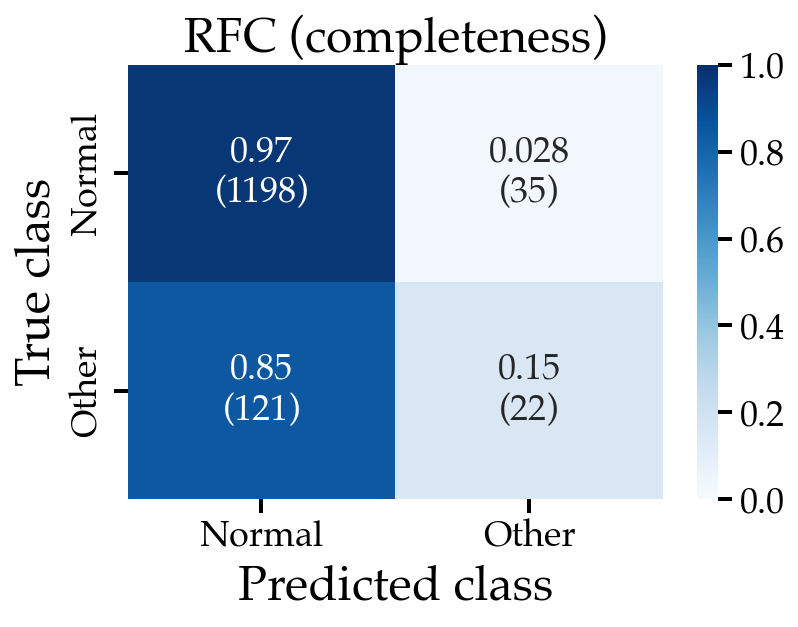

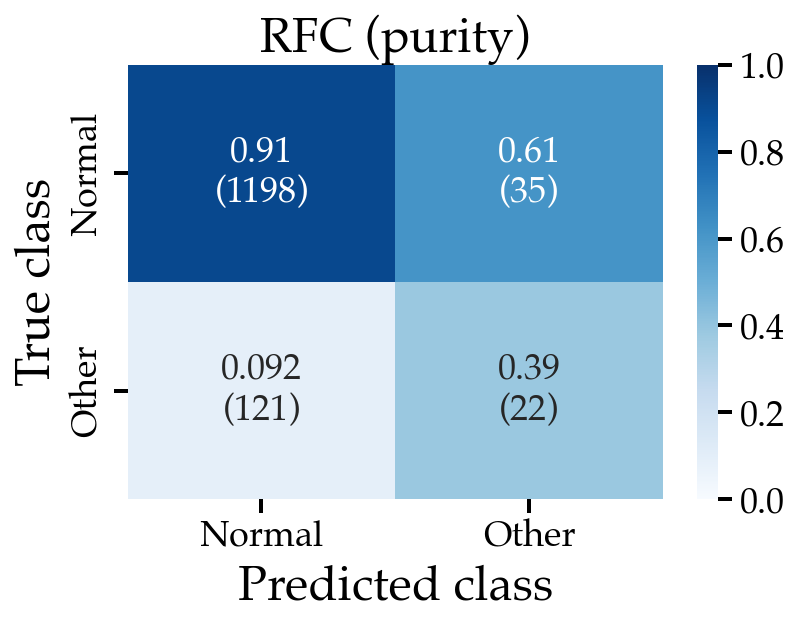

In [34]:
# Confusion matrices
title='RFC'
true_labels = np.array(merged_df['Obj. Type 2cls'])
predicted_labels = np.array(merged_df['RFC_best_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND)
    #plt.savefig(f'{cm_path}/confmatrix_before_lc_feature_extractor_timeseries_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.savefig(f'{cm_path}/confmatrix_before_lc_feature_extractor_fullLConly_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')

    plt.show()
    plt.close()

In [35]:
mislabeled_df = merged_df[(merged_df['Obj. Type 2cls'] == "Normal") & (merged_df['RFC_best_cls'] == "Other")]
mislabeled_df

,Name,RA,DEC,Obj. Type,Redshift,Host Name,Host Redshift,Reporting Group/s,Discovery Data Source/s,Classifying Group/s,...,Discovery Mag/Flux,Discovery Filter,Discovery Date (UT),Sender,Remarks,Discovery Bibcode,Classification Bibcodes,Ext. catalog/s,RFC_best_cls,Obj. Type 2cls
Disc. Internal Name,,,,,,,,,,,,,,,,,,,,,
ZTF20abxpzxg,SN 2020sin,01:17:37.417,+16:52:50.61,SN Ia,0.077000,SDSS J011737.31+165254.3,0.094000,"ALeRCE, ZTF, Pan-STARRS, ATLAS","ZTF, Pan-STARRS, ATLAS",None,...,20.9838,g-ZTF,2020-08-26 11:25:34.997,ALeRCE,NaN,2020TNSTR2687....1F,2020TNSCR2902....1T,NaN,Other,Normal
ZTF20abxmgny,SN 2020sgc,18:43:44.524,+66:47:47.10,SN Ia,0.090000,2MASS J18434453+6647473,NaN,"ALeRCE, ZTF",ZTF,ZTF,...,18.4474,g-ZTF,2020-08-29 07:34:55.998,ALeRCE,NaN,2020TNSTR2667....1F,2020TNSCR2724....1D,NaN,Other,Normal
ZTF20abxfiev,SN 2020sfs,02:41:25.247,+13:20:22.34,SN Ia,0.080000,NaN,NaN,"ZTF, Pan-STARRS, ATLAS","ZTF, Pan-STARRS, ATLAS",ZTF,...,20.0000,g-ZTF,2020-08-27 12:00:06.048,ZTF_AMPEL_COMPLETE,NaN,2020TNSTR2670....1N,2020TNSCR2830....1G,NaN,Other,Normal
ZTF20abxcycq,SN 2020scn,22:07:52.435,-10:33:32.09,SN Ia,0.082073,NaN,NaN,"ZTF, Pan-STARRS","ZTF, Pan-STARRS",ZTF,...,20.3500,r-ZTF,2020-08-21 06:27:21.600,ZTF_Bot1,NaN,2020TNSTR2629....1F,2020TNSCR2724....1D,NaN,Other,Normal
ZTF20abwynwj,SN 2020sbx,01:17:50.390,+21:15:47.21,SN Ia,0.060000,SDSS J011750.43+211546.6,0.078000,"ALeRCE, ZTF, ATLAS","ZTF, ATLAS",ZTF,...,20.0195,r-ZTF,2020-08-26 09:12:25.001,ALeRCE,NaN,2020TNSTR2609....1F,2020TNSCR2799....1D,NaN,Other,Normal
ZTF20abpyxja,SN 2020riy,23:54:59.965,+49:28:54.89,SN Ia,0.050000,NaN,NaN,"SGLF, ATLAS","ZTF, ATLAS",ZTF,...,20.0790,r-ZTF,2020-08-01 11:44:40.000,Perez-Fournon,NaN,2020TNSTR2500....1P,2020TNSCR2525....1D,NaN,Other,Normal
ZTF20abjkxwa,SN 2020oao,01:43:49.838,+30:21:13.99,SN Ia,0.054000,NaN,NaN,ZTF,ZTF,ZTF,...,17.6000,g-ZTF,2020-07-02 11:30:09.792,ZTF_AMPEL_NEW,NaN,2020TNSTR2048....1N,2020TNSCR2169....1D,NaN,Other,Normal
ZTF20abipuee,SN 2020npt,19:04:26.237,+55:14:45.92,SN Ia,0.050000,NaN,NaN,ZTF,ZTF,ZTF,...,19.5200,r-ZTF,2020-06-28 05:35:53.664,ZTF_AMPEL_NEW,NaN,2020TNSTR1970....1N,2020TNSCR2127....1P,NaN,Other,Normal
ZTF20abfcdkj,SN 2020mst,18:47:10.541,+60:29:48.43,SN II,0.059000,NaN,NaN,"SGLF, ZTF, ATLAS","ZTF, ATLAS",ZTF,...,20.8280,g-ZTF,2020-06-13 06:00:21.000,Perez-Fournon,NaN,2020TNSTR1821....1A,2020TNSCR2128....1Z,NaN,Other,Normal


In [36]:
for obj, cls, cls2, rfc_cls in zip(mislabeled_df.index, mislabeled_df["Obj. Type"], mislabeled_df["Obj. Type 2cls"], mislabeled_df.RFC_best_cls):
    print(f"https://alerce.online/object/{obj}", cls, cls2, rfc_cls)

https://alerce.online/object/ZTF20abxpzxg SN Ia Normal Other
https://alerce.online/object/ZTF20abxmgny SN Ia Normal Other
https://alerce.online/object/ZTF20abxfiev SN Ia Normal Other
https://alerce.online/object/ZTF20abxcycq SN Ia Normal Other
https://alerce.online/object/ZTF20abwynwj SN Ia Normal Other
https://alerce.online/object/ZTF20abpyxja SN Ia Normal Other
https://alerce.online/object/ZTF20abjkxwa SN Ia Normal Other
https://alerce.online/object/ZTF20abipuee SN Ia Normal Other
https://alerce.online/object/ZTF20abfcdkj SN II Normal Other
https://alerce.online/object/ZTF20aayxkqy SN Ia Normal Other
https://alerce.online/object/ZTF20aambbfn SN Ia Normal Other
https://alerce.online/object/ZTF20aajbsxt SN Ia Normal Other
https://alerce.online/object/ZTF20aahdwze SN Ia Normal Other
https://alerce.online/object/ZTF20aadvaoi SN Ia Normal Other
https://alerce.online/object/ZTF20aaaxrad SN Ia Normal Other
https://alerce.online/object/ZTF19acklbjr SN Ia Normal Other
https://alerce.online/ob

In [48]:
for obj, cls, cls2, rfc_cls in zip(merged_df.index, merged_df["Obj. Type"], merged_df["Obj. Type 2cls"], merged_df.RFC_best_cls):
    if cls == "SN Ibn":
        print(f"https://alerce.online/object/{obj}", cls, cls2, rfc_cls)

https://alerce.online/object/ZTF20aalrqbu SN Ibn Other Normal
https://alerce.online/object/ZTF19acmbekd SN Ibn Other Normal
https://alerce.online/object/ZTF19abobxik SN Ibn Other Normal
https://alerce.online/object/ZTF19abamqxo SN Ibn Other Normal
https://alerce.online/object/ZTF19aapfmki SN Ibn Other Normal


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


https://alerce.online/object/ZTF19acnfjyw


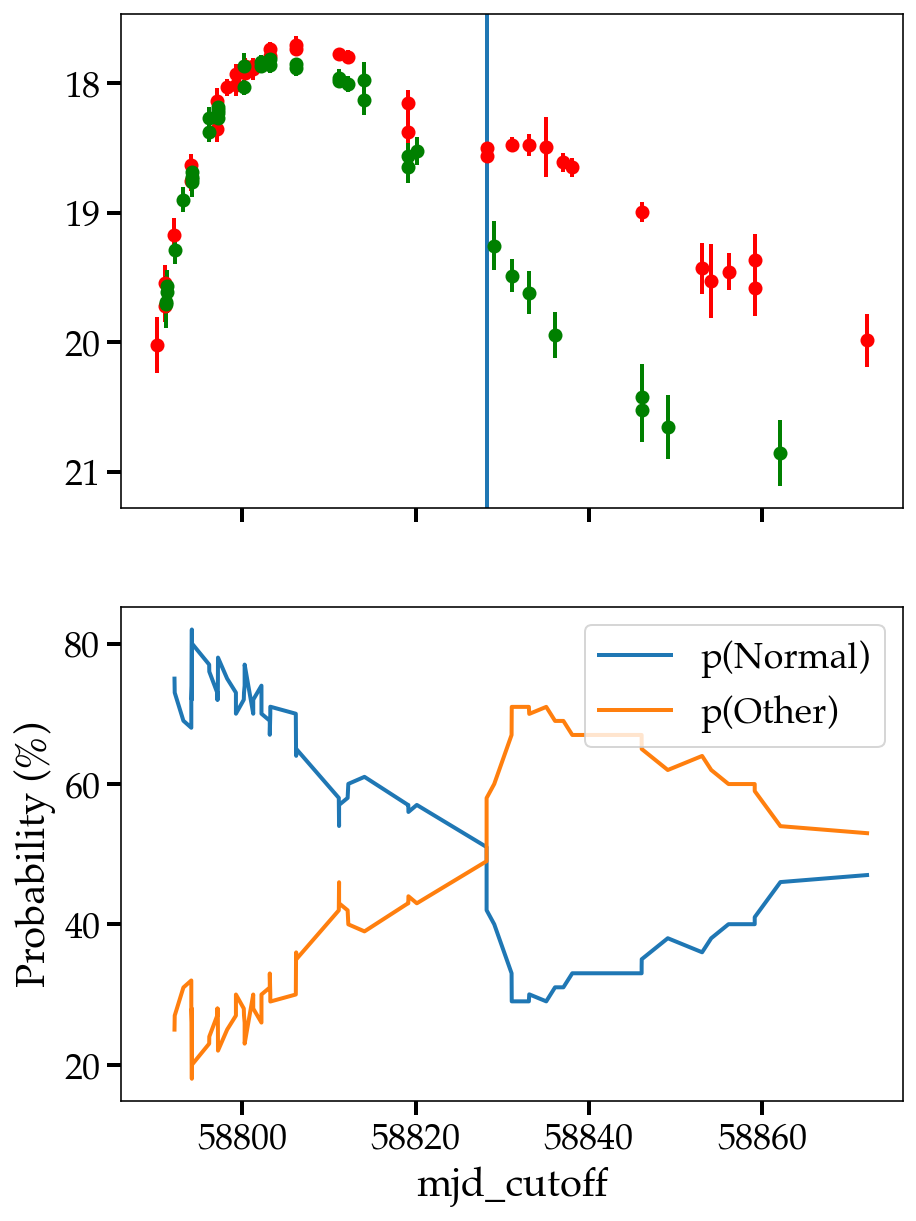

In [38]:
plot_RFC_prob_vs_lc_ztfid(anom_ztfid='ZTF19acnfjyw', 
                          anom_thresh=50, 
                          df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/before_lc-feature-extractor_tns_search/timeseries"
                         )